In [2]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from pandas import Timestamp
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

In [3]:
excel_file = pd.ExcelFile("queues_2023_clean_data.xlsx")
interconnection_data = excel_file.parse("data")

In [4]:
interconnection_data.drop(["q_year", "prop_year"], axis=1, inplace=True)

In [5]:
date_columns = ["q_date", "ia_date", "wd_date", "on_date", "prop_date"]
for col in date_columns:
    interconnection_data[col] = pd.to_datetime(
        interconnection_data[col], errors="coerce"
    )


interconnection_data

,q_id,q_status,q_date,ia_date,wd_date,on_date,entity,project_name,developer,utility,...,prop_date,IA_status_raw,IA_status_clean,type_clean,type1,type2,type3,mw1,mw2,mw3
0,GIA-50,withdrawn,2014-12-18,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2016-12-01,Withdrawn,Withdrawn,Wind,Wind,NaN,NaN,300.0,NaN,NaN
1,GIA-105,active,2022-07-21,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2025-10-01,FS,Facilities Study,Gas,Gas,NaN,NaN,460.0,NaN,NaN
2,GIA-83,active,2019-06-19,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2025-07-01,GIA,IA Executed,Wind,Wind,NaN,NaN,1018.0,NaN,NaN
3,GIA-113,active,2023-01-13,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2026-12-01,SIS,System Impact Study,Wind,Wind,NaN,NaN,500.0,NaN,NaN
4,GIA-73,withdrawn,2018-11-19,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2021-10-01,Withdrawn,Withdrawn,Solar,Solar,NaN,NaN,300.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32508,2023-G2,active,2023-03-01,NaT,NaT,NaT,WAPA-SN,NaN,NaN,WAPA-SN,...,NaT,"FEC,SISE",System Impact Study,Solar+Battery,Solar,Battery,NaN,800.0,NaN,NaN
32509,2015-G1,withdrawn,2015-01-26,NaT,NaT,NaT,WAPA-SN,NaN,NaN,WAPA-SN,...,NaT,"FENR, SISC, FSE, W",Facility Study,Solar,Solar,NaN,NaN,26.0,NaN,NaN
32510,2023-G3,withdrawn,2023-03-24,NaT,NaT,NaT,WAPA-SN,NaN,NaN,WAPA-SN,...,NaT,Scoping,Not Started,Solar+Battery,Solar,Battery,NaN,100.0,NaN,NaN
32511,2019-G1,active,2019-08-08,NaT,NaT,NaT,WAPA-SN,NaN,NaN,WAPA-SN,...,NaT,"FEC, SISC, FSE",Facility Study,Solar+Battery,Solar,Battery,NaN,300.0,NaN,NaN


In [6]:
def categorical_change(data, column):
    """Changes a column into categorical variables"""
    i = 0
    seen = {}
    categorical = []
    for _, row in data.iterrows():
        item = row[column]
        if item not in seen:
            seen[item] = i
            i += 1
        categorical.append(seen[item])
    data[column] = categorical


def select_iso(data, *isos):
    "Extracts data from select isos"
    result = []
    for iso in isos:
        result.append(data[data["entity"] == iso])
    result = tuple(result)
    return result


def sort_iso(*isos):
    """Sort ISO by the date they entred the queue"""
    result = []
    for iso in isos:
        sorted_iso = iso.sort_values(by="q_date", ascending=True)
        result.append(sorted_iso)
    result = tuple(result)
    return result


def calculate_difference(df, unit="years"):
    """For projects that have been deployed, calculates
    the time difference between the start date and end date."""

    time_difference = []

    for index, row in df.iterrows():
        delta_days = (row["on_date"] - row["q_date"]).days

        if unit == "years":
            time_difference.append(delta_days / 365.25)
        elif unit == "months":
            time_difference.append(delta_days / 30.44)
        elif unit == "days":
            time_difference.append(float(delta_days))
    return time_difference


def data_split(iso, time_unit="days", randomness=True):
    iso = iso[iso["on_date"].notna()]  # only select projects that have been deployed
    iso["time_difference"] = calculate_difference(iso, "days")
    categorical_columns = ["type1", "type2", "type3"]
    for col in categorical_columns:
        categorical_change(iso, col)
    X = np.nan_to_num(
        iso[["type1", "type2", "type3", "mw1", "mw2", "mw3", "queue"]].to_numpy()
    ) # the size/time + mw of the queue per type of the last few projects
    y = np.nan_to_num(iso["time_difference"].to_numpy())
    if randomness:
        return train_test_split(X, y, test_size=0.3, random_state=42)
    else:
        return train_test_split(X, y, test_size=0.3)


def queue_length(iso, initial_queue=0):
    """Calculates the queue length over time based on project additions, completions, and withdrawals."""
    queues = np.zeros(iso.shape[0])
    queues[0] = initial_queue

    completion_dates = sorted(iso[iso["on_date"].notna()]["on_date"].tolist())
    withdraw_dates = sorted(iso[iso["wd_date"].notna()]["wd_date"].tolist())

    print(f"Total Completed Projects: {len(completion_dates)}")
    print(f"Total Withdrawn Projects: {len(withdraw_dates)}")

    first_completion_date = (
        completion_dates[0] if completion_dates else Timestamp("2099-12-12")
    )
    first_withdraw_date = (
        withdraw_dates[0] if withdraw_dates else Timestamp("2099-12-12")
    )

    for i, (_, row) in enumerate(iso.iterrows()):
        current_time = row["q_date"]

        if i > 0:
            queues[i] = queues[i - 1]

        queues[i] += 1

        while (
            first_completion_date <= current_time or first_withdraw_date <= current_time
        ):
            if first_completion_date <= first_withdraw_date:
                queues[i] -= 1
                completion_dates.pop(0)
                first_completion_date = (
                    completion_dates[0] if completion_dates else Timestamp("2099-12-12")
                )
            else:
                queues[i] -= 1
                withdraw_dates.pop(0)
                first_withdraw_date = (
                    withdraw_dates[0] if withdraw_dates else Timestamp("2099-12-12")
                )

        queues[i] = max(queues[i], 0)

    return queues


caiso, ercot, pjm, iso_ne = select_iso(
    interconnection_data, "CAISO", "ERCOT", "PJM", "ISO-NE"
)
sorted_caiso, sorted_ercot, sorted_pjm, sorted_iso_ne = sort_iso(
    caiso, ercot, pjm, iso_ne
)

Total Completed Projects: 137
Total Withdrawn Projects: 281


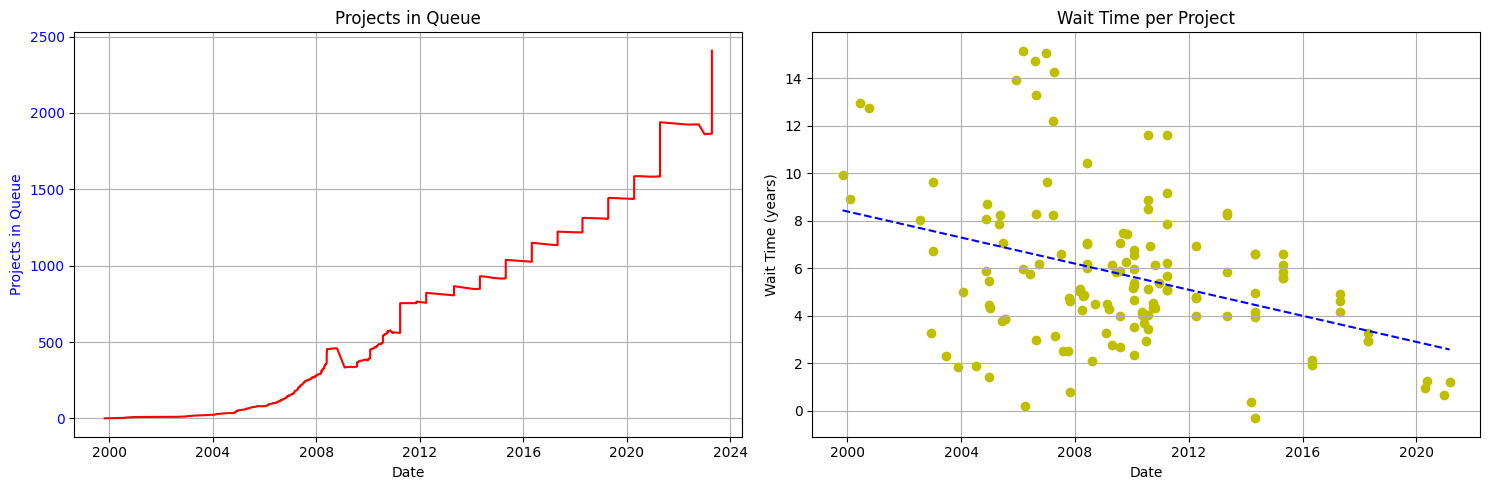

Total Completed Projects: 191
Total Withdrawn Projects: 45


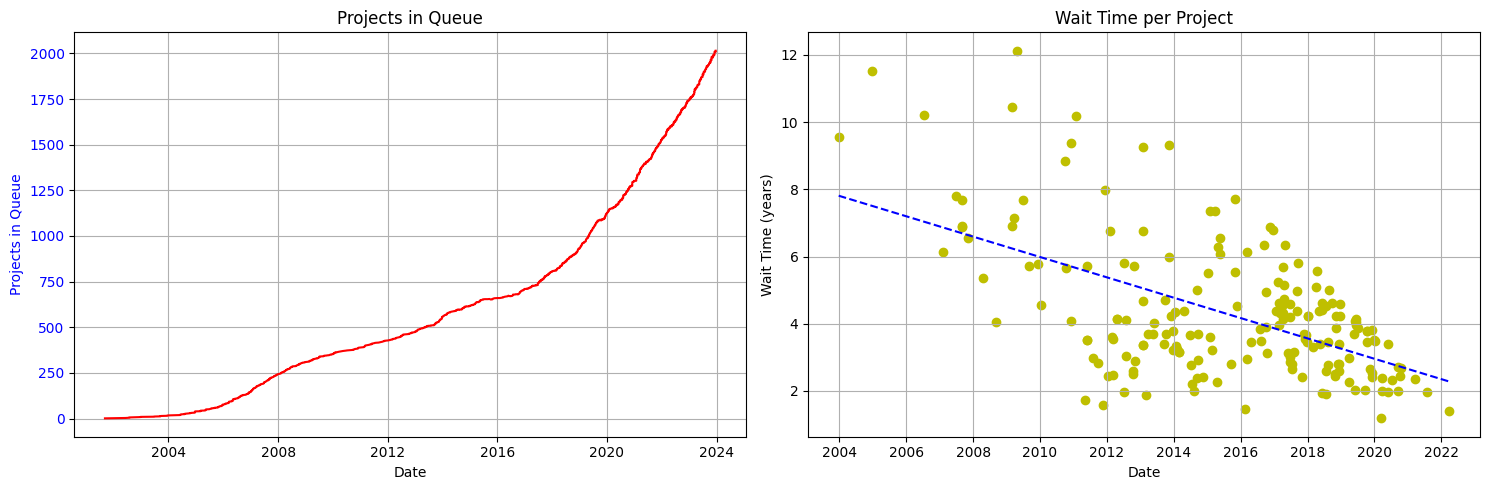

Total Completed Projects: 178
Total Withdrawn Projects: 92


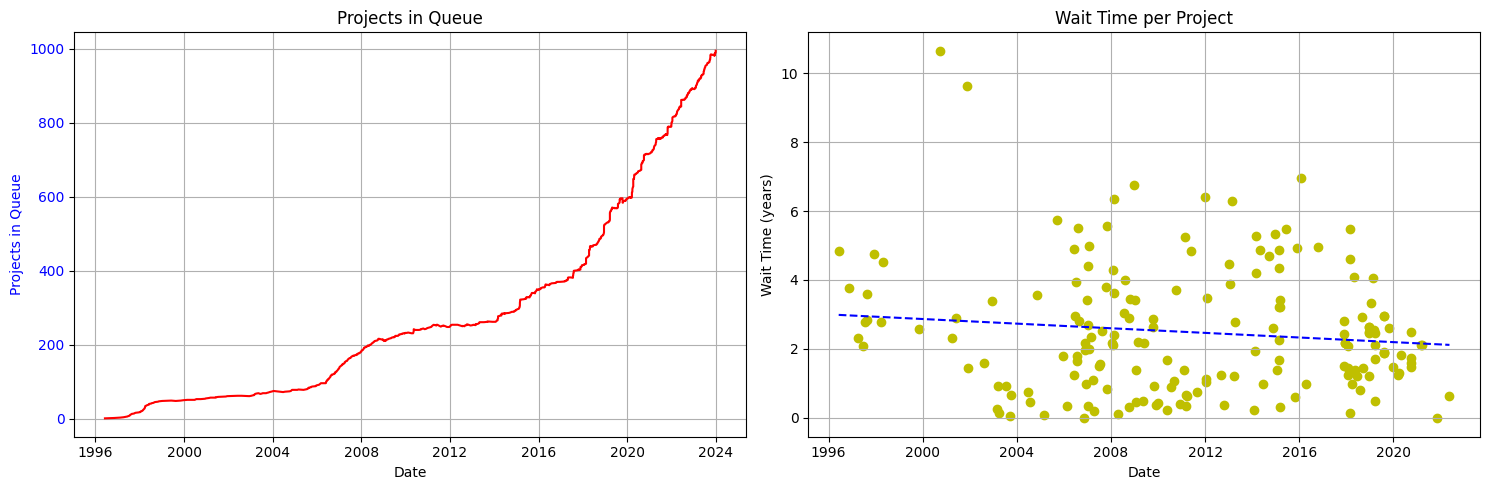

In [29]:
import matplotlib.pyplot as plt

iso_list = {
    "California": sorted_caiso,
    "ERCOT": sorted_ercot,
    # "PJM": sorted_pjm,
    "New England": sorted_iso_ne,
}
for name, iso in iso_list.items():
    completed_iso = iso[iso["on_date"].notna()]
    time_difference = calculate_difference(completed_iso)
    completed_dates = completed_iso["q_date"]
    queue = queue_length(iso)
    iso["queue"] = queue
    dates = iso["q_date"]

    # Create two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # First plot (Queue of Projects)
    ax1.plot(dates, queue, '-r', label="Projects in Queue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Projects in Queue", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title("Projects in Queue")
    ax1.grid()

    # Second plot (Wait Time per Project with Trend Line)
    ax2.scatter(completed_dates, time_difference, color='y', label="Wait Time per Project")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Wait Time (years)")
    ax2.tick_params(axis='y',)

    # Convert dates to numerical format for the trend line
    completed_dates_num = completed_dates.map(pd.Timestamp.toordinal)  # Convert dates to numbers
    coeffs = np.polyfit(completed_dates_num, time_difference, 1)  # Linear fit (degree=1)
    best_fit_line = np.polyval(coeffs, completed_dates_num)  # Compute best-fit values

    # Plot the best-fit line
    ax2.plot(completed_dates, best_fit_line, '--b', label="Trend Line")
    ax2.set_title("Wait Time per Project")
    ax2.grid()

    # Improve layout and show
    fig.tight_layout()
    plt.show()

In [ ]:
    fig, ax1 = plt.subplots()

    # Plot the first dataset (queue projects over time)
    ax1.plot(dates, queue, '-r', label="Projects in Queue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Projects in Queue", color='b')
    # ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot the second dataset (wait times for completed projects)
    ax2.scatter(completed_dates, time_difference, color='y', label="Wait Time per Project")
    ax2.set_ylabel("Wait Time (days)", color='r')
    # ax2.tick_params(axis='y', labelcolor='r')

    # # Improve layout and show
    # fig.autofmt_xdate()
    # fig.tight_layout()
    plt.title("Project Queue and Wait Times")
    plt.show()

### Linear Regression for Deployed  Power Plants

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def linear_regression(iso, randomness=False):

    X_train, X_test, y_train, y_test = data_split(iso, randomness=randomness)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)
    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = linear_regression(iso,True)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

R^2 Performance on seen data for Caiso :0.39478832732962166 

R^2 Performance on unseen data for Caiso :0.2573331820147088 

R^2 Performance on seen data for Ercot :0.3282292752647936 

R^2 Performance on unseen data for Ercot :0.12361395974439493 

R^2 Performance on seen data for NE :0.03939880416415931 

R^2 Performance on unseen data for NE :-0.10910086877536318 



In [32]:
from sklearn.ensemble import RandomForestRegressor


def random_forests(iso,randomness = False):

    X_train, X_test, y_train, y_test = data_split(iso, randomness=randomness)
    regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)
    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = random_forests(iso,True)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

R^2 Performance on seen data for Caiso :0.8727427875600429 

R^2 Performance on unseen data for Caiso :0.26481589209635525 

R^2 Performance on seen data for Ercot :0.8708017005103321 

R^2 Performance on unseen data for Ercot :-0.04116622213130161 

R^2 Performance on seen data for NE :0.869792565686283 

R^2 Performance on unseen data for NE :-0.4559607986188301 



include queue times, in the previous 4 or 5 projects

In [34]:
from sklearn.tree import DecisionTreeRegressor


def decision_tree(iso,randomness):
    """Train and evaluate a Decision Tree Regressor on the given dataset."""

    X_train, X_test, y_train, y_test = data_split(iso, randomness=randomness)

    regressor = DecisionTreeRegressor()

    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)

    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)

    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = decision_tree(iso,True)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

R^2 Performance on seen data for Caiso :0.9994598936864239 

R^2 Performance on unseen data for Caiso :-0.9194687358978717 

R^2 Performance on seen data for Ercot :1.0 

R^2 Performance on unseen data for Ercot :-0.46991010946278067 

R^2 Performance on seen data for NE :1.0 

R^2 Performance on unseen data for NE :-0.580509850803451 

